In [2]:
import pandas as pd

# Define column names as per Sentiment140 dataset
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv(r"C:\Users\sudip\OneDrive\Desktop\tweeter sentiment project\training.1600000.processed.noemoticon.csv", 
                 encoding='ISO-8859-1', names=columns)

df = df[['target', 'text']]  # Only keep sentiment and tweet
df['target'] = df['target'].replace({0: 0, 4: 1})  # 0 = Negative, 1 = Positive
df.head()



,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'http\S+|@\S+|#\S+', '', text)  # remove URLs, mentions, hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)       # remove non-alphabetic chars
    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['clean_text'] = df['text'].apply(clean_text)
df = df[df['clean_text'].str.strip() != '']  # drop empty rows
df.head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudip\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 20000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# Features and labels
X = padded
y = df['target'].values


TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [1]:
import tensorflow as tf
import numpy as np
print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)


TensorFlow: 2.10.0
NumPy: 1.24.4


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sudip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv(r"C:\Users\sudip\OneDrive\Desktop\tweeter sentiment project\training.1600000.processed.noemoticon.csv", 
                 encoding='ISO-8859-1', header=None)

df = df[[0, 5]]
df.columns = ['sentiment', 'text']

# Mapping sentiment
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})  # 0 = Negative, 4 = Positive
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle

df.head()


,sentiment,text
0,1,"is so tried, but looking forward to watchingca..."
1,0,i hate hospitals ...
2,1,OK its so cold. Hmm.. i wanna have a warm bath...
3,0,HOLY SHIT. Craven SigSvr is up to 100. SigTor ...
4,0,I was thinking of retweeting Iran filter news ...


In [4]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'@\w+', '', text)     # Remove mentions
    text = re.sub(r'#\w+', '', text)     # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df['cleaned_text'].head()


0    tried looking forward watchingca double episod...
1                                       hate hospitals
2                          ok cold hmm wanna warm bath
3    holy shit craven sigsvr 100 sigtor 4 rare supe...
4    thinking retweeting iran filter news proxies i...
Name: cleaned_text, dtype: object

In [5]:
vocab_size = 10000
max_len = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_text'])

sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X = padded_sequences
y = df['sentiment'].values


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
model = Sequential([
    Embedding(vocab_size, 64, input_length=max_len),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 675,137
Trainable params: 675,137
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=3, batch_size=512, validation_data=(X_test, y_test))


Epoch 1/3
2500/2500 [==============================] - 1130s 451ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 2/3
2500/2500 [==============================] - 1027s 411ms/step - loss: 0.6932 - accuracy: 0.4993 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 3/3
2500/2500 [==============================] - 1065s 426ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4988


In [9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")


10000/10000 [==============================] - 156s 16ms/step - loss: 0.6932 - accuracy: 0.4988
Test Accuracy: 49.88%


10000/10000 [==============================] - 149s 15ms/step


c:\Users\sudip\anaconda3\envs\tf-nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sudip\anaconda3\envs\tf-nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sudip\anaconda3\envs\tf-nlp-env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

              precision    recall  f1-score   support

           0       0.50      1.00      0.67    159606
           1       0.00      0.00      0.00    160394

    accuracy                           0.50    320000
   macro avg       0.25      0.50      0.33    320000
weighted avg       0.25      0.50      0.33    320000



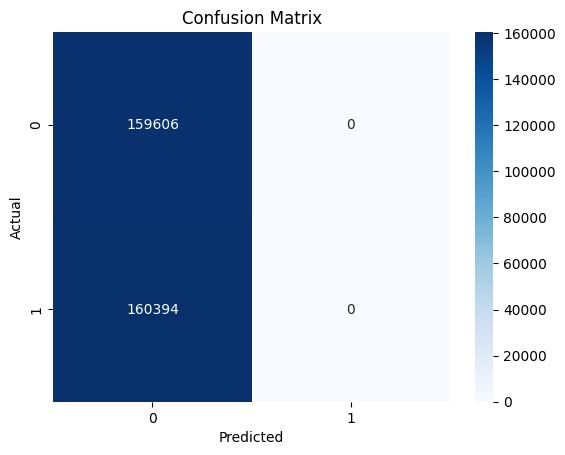

In [10]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [11]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len)
    pred = model.predict(pad)[0][0]
    sentiment = "Positive" if pred > 0.5 else "Negative"
    return sentiment

print(predict_sentiment("I love this! Amazing product."))
print(predict_sentiment("I hate this so much. Worst ever."))


1/1 [==============================] - 0s 342ms/step
Negative
1/1 [==============================] - 0s 28ms/step
Negative
